# **Pneumonia Classification Using VGG16 💻**

This Code was done by Dr. Kaneeka Vidanage and modified by Manith Jayaba according to the requirement

Dataset Link - https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data

## Install Necessary Dependencies (Optional if you're using Colab) 😏

In [ ]:
!pip install tensorflow
!pip install scipy
!pip install kaggle

## Import Dataset 🛬


Need to get the **Kaggle api key file (.json file)** from Kaggle settings page



In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"manithj","key":"616e59e526cfd23815c489ca17c33302"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:00<00:00, 40.6MB/s]
100% 2.29G/2.29G [01:00<00:00, 40.5MB/s]


In [4]:
!unzip /content/chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

## Train the Model 🚀

In [5]:
from tensorflow import keras
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [8]:
vgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
# disreguard the final fully connected layer, which does the classification. We do this, in situations, if we need to customize
# the final outputs. Usually, VGG 16 has close to 1000 output classes. But here for pneumonia prediction we need only two classes
# as positive and negative.

# we use this strategy for situations, where we need the embeddings generated from the model to be plugged with another
# customized requirements.

58889256/58889256 [==============================] - 2s 0us/step


In [9]:
# prevent weights adjustments of the VGG modle during the training procedure. So it will have the pretrained imagenet weights.
for layer in vgg.layers:
    layer.trainable = False

You have to change the path according to your train directory

In [10]:
folders = glob('/content/chest_xray/train/*')
x = Flatten()(vgg.output) # flatten the embeddings generated to one single tensor, overl the 1000s of tensors output

In [11]:
# use the derived flattened tensor and re-use it to create a custom and trainable dense layer for us to get the binary class
# output we need as penumonia positive / negative. Hence it`s binary classed, we can use softmax either.
prediction = Dense(len(folders), activation='softmax')(x)
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
# configure the back prop pipiline
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [13]:
# used for the image augmentation process.
from keras.preprocessing.image import ImageDataGenerator

You have to change the path according to your train & test directory

In [14]:
# augmentation pipeline
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)




# Make sure you provide the same target size as initialied for the image size
# batch size means, size of images you take from the dataset for one backprop training.
# one epoc has multiple batches. Untill the dataset size is reached , batches are taken inside the given epoc.
# once the entire datset is taken inside, first epoc will be completed. Then repeat the same process for the other epocs as well
training_set = train_datagen.flow_from_directory('/content/chest_xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 10,
                                                 class_mode = 'categorical')




test_set = test_datagen.flow_from_directory('/content/chest_xray/test',
                                            target_size = (224, 224),
                                            batch_size = 10,
                                            class_mode = 'categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [15]:
# training procedure
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-15-eb388ed5003c>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/5
522/522 [==============================] - 133s 244ms/step - loss: 0.1969 - accuracy: 0.9283 - val_loss: 0.9115 - val_accuracy: 0.7580
Epoch 2/5
522/522 [==============================] - 126s 241ms/step - loss: 0.1572 - accuracy: 0.9498 - val_loss: 0.3797 - val_accuracy: 0.9071
Epoch 3/5
522/522 [==============================] - 125s 239ms/step - loss: 0.1288 - accuracy: 0.9574 - val_loss: 0.4113 - val_accuracy: 0.9119
Epoch 4/5
522/522 [==============================] - 123s 236ms/step - loss: 0.1223 - accuracy: 0.9636 - val_loss: 0.4902 - val_accuracy: 0.8990
Epoch 5/5
522/522 [==============================] - 129s 248ms/step - loss: 0.1360 - accuracy: 0.9617 - val_loss: 0.4237 - val_accuracy: 0.9135


## Accuracy Charts 📈

<ipython-input-18-b5fd665b164d>:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(epochs, train_acc , 'ro-', label ='Training accuracy',marker='o' )
<ipython-input-18-b5fd665b164d>:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "go-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(epochs, val_acc ,'go-', label='Validation accuracy', marker='o')


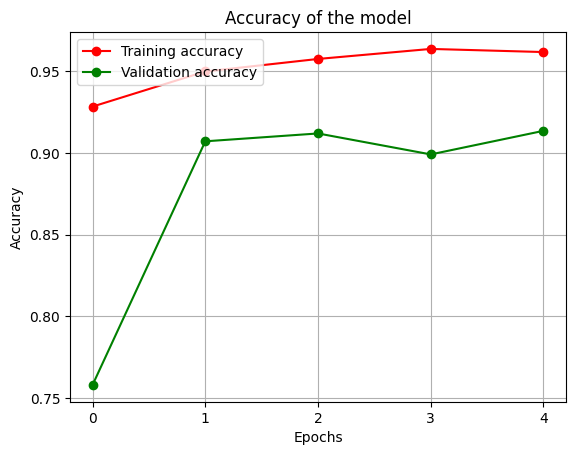

In [18]:
train_acc =r.history['accuracy']
val_acc =r.history['val_accuracy']
epochs=range(len(train_acc))

plt.plot(epochs, train_acc , 'ro-', label ='Training accuracy',marker='o' )
plt.plot(epochs, val_acc ,'go-', label='Validation accuracy', marker='o')
plt.title('Accuracy of the model')
plt.legend(loc='upper left')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)  # x-axis ticks to be the same as epochs
plt.grid()
plt.show()

<ipython-input-19-c11d592b389a>:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(epochs, train_loss , 'ro-', label ='Training loss' ,marker='o')
<ipython-input-19-c11d592b389a>:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "go-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(epochs, val_loss ,'go-', label='Validation loss',marker='o')


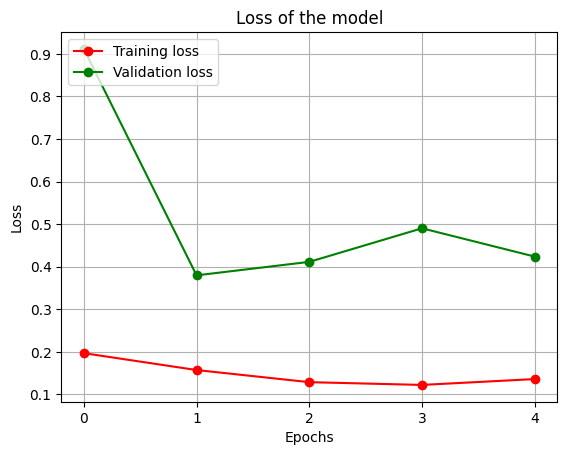

In [19]:
train_loss=r.history['loss']
val_loss= r.history['val_loss']

plt.plot(epochs, train_loss , 'ro-', label ='Training loss' ,marker='o')
plt.plot(epochs, val_loss ,'go-', label='Validation loss',marker='o')
plt.title('Loss of the model')
plt.legend(loc='upper left')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid()
plt.show()

## Saving the Model ✅

In [20]:
import tensorflow as tf
from keras.models import load_model

model.save('chest_xray.h5') # save the trained modle

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Inferencing the Model 🧪

In [21]:
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input # import the model`s skeleton
import numpy as np

In [22]:
model=load_model('chest_xray.h5')

In [23]:
#load the test image
#tf.keras.utils.load_img
img=tf.keras.utils.load_img('/content/image.jpeg',target_size=(224,224))

x=tf.keras.preprocessing.image.img_to_array(img) # image as a numpy array

x=np.expand_dims(x, axis=0)

img_data=preprocess_input(x) # organize for the prediction

In [24]:
classes=model.predict(img_data)

1/1 [==============================] - 1s 1s/step


In [25]:
result=int(classes[0][0])

In [26]:
if result== 0:
    print("Person is Affected By PNEUMONIA")
else:
    print("Result is Normal")

Person is Affected By PNEUMONIA
